In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay , classification_report
from sklearn.preprocessing  import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
torch.manual_seed(RANDOM_STATE)

TEST_SIZE = 0.2
EPOCHS = 51 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.jet

plt.rcParams.update(params)

In [3]:
# Basic Hyper-parameter

inpDir = os.path.join('..','..','input')
outDir = os.path.join('..','output')
modelDir = os.path.join('..','models')
subDir = 'fifa 2019'

if not os.path.exists(outDir):
  os.makedirs(outDir)

if not os.path.exists(modelDir):
  os.makedirs(modelDir)

if not os.path.exists(os.path.join(modelDir, subDir)):
  os.makedirs(os.path.join(modelDir, subDir))

In [4]:
# # for, Physical device :
# physical_device = tf.config.list_physical_devices('GPU')
# if len(physical_device) > 0:
#    tf.config.experimental.set_memory_growth(physical_device[0], True)

In [5]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/fifa_2019.csv')
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
cols = data_df.columns

for col in cols:
  print(f'\n Column : {col} - {data_df[col].unique()}')


 Column : Unnamed: 0 - [    0     1     2 ... 18204 18205 18206]

 Column : ID - [158023  20801 190871 ... 241638 246268 246269]

 Column : Name - ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

 Column : Age - [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

 Column : Photo - ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

 Column : Nationality - ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Swe

In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [8]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [9]:
rel_cols = ['Position','Finishing','HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
             'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
             'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
             'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
             'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
             'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
             'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
goalkeeper = 'GK'
forward = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
midfielders = ['CM', 'LCM',  'RCM', 'CDM', 'RDM' ,'LAM', 'CAM', 'RAM', 'LM', 'RM', 'LDM' ]
defenders = [ 'LWB', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [11]:
# Goal Keepers :
data_df.loc[data_df['Position'] == 'GK', 'Position'] =0

# Defenders :
data_df.loc[data_df['Position'].isin(defenders), 'Position'] = 1

# Mid - fielders :
data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

# Forward :
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3

# Prevent pandas from complaining
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [12]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, stratify=data_df['Position'], random_state=RANDOM_STATE)

train_df.shape, test_df.shape

((14517, 34), (3630, 34))

The below is instanciated in torch so that we can know where the program is running

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} for execution')

Using cpu for execution


### Custom Datasets

In [14]:
''' Using Singleton Class - Singleton Design Pattern '''

class GlobalScaler:
  _instance = None     # Instance None

  def __init__(self):
     if GlobalScaler._instance is not None:
       raise Exception('GlobalScaler is a singleton class')
     self.scaler = StandardScaler()     # instantiate a scaler

  @classmethod
  def get_instance(cls):
    if cls._instance is None:
      cls._instance = GlobalScaler()
    return cls._instance

In [15]:
sc = GlobalScaler.get_instance()
sc

# <__main__.GlobalScaler at 0x7df2630dcf10>

In [16]:
class FifaDS(Dataset):
  globalscaler = GlobalScaler.get_instance()

  def __init__(self, dataframe, device, is_train, label_col):
    super().__init__()
    self.df = dataframe
    self.device = device
    self.is_train = is_train
    self.label_col = label_col
    self.scaler = self.globalscaler.scaler

    # Split in Features and Labels, and scale

    if self.is_train:
      self.label = self.df[label_col].to_numpy()
      X = self.df.drop(label_col, axis=1)
      self.features = self.scaler.fit_transform(X)  # Train Data

    else:
      self.label = self.df[label_col].to_numpy()
      X = self.df.drop(label_col, axis=1)
      self.features = self.scaler.transform(X)    # Other Data

  def __len__ (self):
    return len(self.features)

  def __getitem__(self, index):
    # Extract features and labels from dataframe
    features = self.features[index]
    label = self.label[index]

    # convert to PyTorch Tensors
    features = torch.tensor(features, dtype=torch.float32, device=self.device)
    label = torch.tensor(label, dtype=torch.int64, device=self.device)
    return features, label

In [17]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


In [18]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


In [19]:
label_col = 'Position'
train_ds = FifaDS(train_df, device=device, is_train=True, label_col=label_col)
test_ds = FifaDS(test_df, device=device, is_train=False, label_col=label_col)

In [20]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184]),
 tensor(3))

Prepare Model

In [21]:
class Model(nn.Module):

  def __init__(self, input_dim):              # All the layers and their sizes are defined here
    super(Model, self).__init__()
    hu1 = 16   # Hidden unit 1
    self.layer1 = nn.Linear(input_dim, hu1)
    self.actv1 = nn.ReLU()
    hu2 = 4   # Hidden unit 2
    self.layer2 = nn.Linear(hu1, hu2)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):                     # here only fw is to be told it does the backprop by its own
    x = self.actv1(self.layer1(x))
    x = self.softmax(self.layer2(x))
    return x

net = Model(input_dim=train_df.shape[1]-1).to(device)
print(net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (actv1): ReLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [22]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
next(iter(train_loader))

[tensor([[ 0.1270,  0.9639,  0.8370,  ..., -0.4382, -0.5518, -0.0396],
         [-1.0509,  1.3665,  0.0893,  ..., -0.4989, -0.4341, -0.3742],
         [-0.1291,  0.7913,  0.5651,  ..., -0.5597, -0.3752, -0.0954],
         ...,
         [-1.3582,  0.1585, -1.8138,  ..., -0.5597, -0.4930, -0.0954],
         [ 0.2294, -1.2795, -0.7263,  ..., -0.0739, -0.3752, -0.1511],
         [ 1.3561,  1.1364,  0.1573,  ..., -0.4989, -0.4930, -0.5414]]),
 tensor([1, 1, 2, 2, 0, 3, 1, 1, 2, 3, 3, 1, 3, 0, 2, 1, 1, 0, 2, 2, 1, 3, 2, 3,
         2, 0, 1, 2, 3, 1, 2, 3])]

In [23]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

#optimizers
optimizer = torch.optim.Adam(net.parameters(), lr = ALPHA)
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []

# Iteration
for epoch in range(EPOCHS):
  # Training Loop
  train_loss, train_acc = 0.0, 0.0
  net.train()   # set mode to training mode
  for i, data in enumerate(train_loader):
    inputs, labels = data
    predict_prob = net(inputs)
    preds = predict_prob.argmax(dim=1)
    batch_loss = loss_fn(predict_prob, labels)
    batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    # Back propagation
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    # Assemble Train loss
    train_loss += batch_loss.item()*inputs.size(0)
    train_acc += batch_acc*inputs.size(0)
  train_loss /= len(train_ds)
  train_acc /= len(train_ds)
  loss.append(train_loss)
  acc.append(train_acc)

  # Testing Loop
  with torch.no_grad():
    test_loss, test_acc = 0.0, 0.0
    net.eval()    # Evaluation of Model
    for data in test_loader:
      inputs, labels = data
      predict_prob = net(inputs)
      preds = predict_prob.argmax(dim=1)
      batch_loss = loss_fn(predict_prob, labels)
      batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
      # Assemble test loss
      test_loss += batch_loss.item()*inputs.size(0)
      test_acc += batch_acc* inputs.size(0)
    test_loss /= len(test_ds)
    test_acc /= len(test_ds)
    tloss.append(test_loss)
    tacc.append(test_acc)

  n_epoch.append(epoch)
  if epoch%5 == 0:
    fmtStr = 'Epoch: {:05d}/{:05d}  --- Loss : {:.5f}/{:.5f} | Acc: {:.5f}/{:.5f}'
    print(fmtStr.format(epoch, EPOCHS, train_loss, test_loss,train_acc, test_acc))

Epoch: 00000/00051  --- Loss : 0.60553/0.37769 | Acc: 0.76345/0.83691
Epoch: 00005/00051  --- Loss : 0.29325/0.30359 | Acc: 0.88021/0.87163
Epoch: 00010/00051  --- Loss : 0.28434/0.29783 | Acc: 0.88262/0.87548
Epoch: 00015/00051  --- Loss : 0.27874/0.29684 | Acc: 0.88544/0.87658
Epoch: 00020/00051  --- Loss : 0.27511/0.29739 | Acc: 0.88600/0.87493
Epoch: 00025/00051  --- Loss : 0.27218/0.29571 | Acc: 0.88813/0.87603
Epoch: 00030/00051  --- Loss : 0.27030/0.29658 | Acc: 0.88999/0.87769
Epoch: 00035/00051  --- Loss : 0.26903/0.29769 | Acc: 0.89054/0.87741
Epoch: 00040/00051  --- Loss : 0.26783/0.29828 | Acc: 0.88875/0.87934
Epoch: 00045/00051  --- Loss : 0.26607/0.29945 | Acc: 0.89054/0.87410
Epoch: 00050/00051  --- Loss : 0.26524/0.29805 | Acc: 0.89075/0.87879


In [24]:
loss_df = pd.DataFrame({'epoch' : n_epoch,
                        'loss': loss,
                        'test_loss': tloss,
                        'acc': acc,
                        'test_acc': tacc
                        })
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.605534,0.377695,0.763450,0.836915
1,1,0.337914,0.328304,0.861266,0.859780
2,2,0.311915,0.313220,0.872632,0.865840
3,3,0.301401,0.308381,0.876972,0.867493
4,4,0.296383,0.305101,0.879727,0.871074


In [25]:
def fn_plot_tf_hist(hist_df):

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    # print(best)

    props = dict(boxstyle = 'round', facecolor = 'aqua', alpha = 0.4)
    facecolor = 'cyan'
    fontsize = 12
    CMAP = plt.cm.coolwarm
    ax = axes[0]

    hist_df.plot(y=[y2,y4], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y2].min(), hist_df.iloc[-1][y4])


    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Min : {best[y4].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy()[0], best[y4].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy()[0], best[y4].to_numpy()[0] + offset),   #end
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy()[0], color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())

    ax.grid()


    ax = axes[1]
    hist_df.plot(y=[y1,y3], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y1], hist_df.iloc[-1][y3])

    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Best : {best[y3].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0] + offset),
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy(), color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y1.capitalize())

    ax.grid()
    plt.suptitle('Training Perfromance')
    plt.tight_layout()
    plt.show()
    # ax = axes[1]
    # hist_df.plot(y=[y2,y4], ax=axes[0])
    # hist_df.plot(y=[y1,y3], ax=ax)

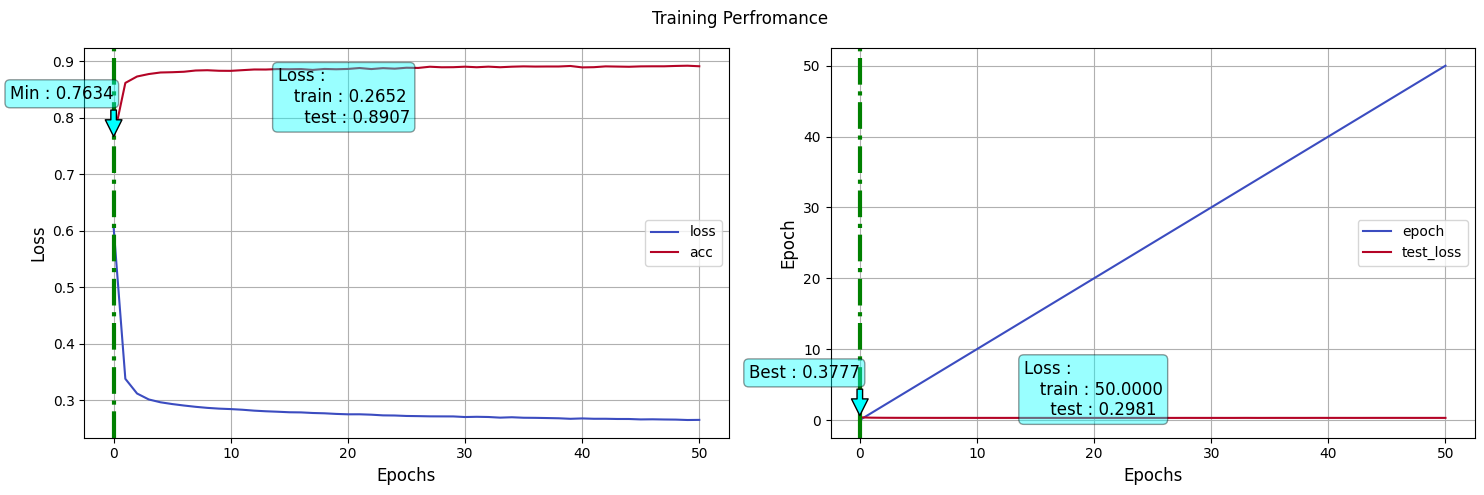

In [26]:
fn_plot_tf_hist(loss_df)

### Train Predictions

In [27]:
y_true, y_pred = [], []
with torch.no_grad():
  net.eval()
  for inputs, labels in train_loader:
    outputs = net(inputs)
    preds = torch.argmax(outputs, dim=1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

  len(y_true), len(y_pred)

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.88      0.78      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



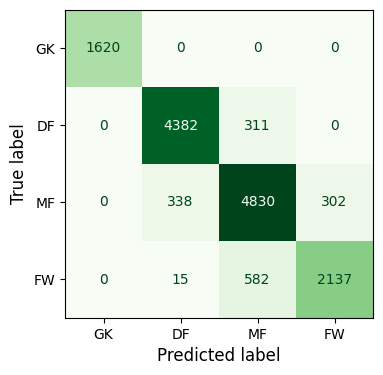

In [29]:
display_labels = ['GK','DF','MF','FW']

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Greens', colorbar=False)